In [1]:
# Librerías
from statsmodels.tsa.stattools import adfuller
import pandas as pd
import numpy as np
import plotly_express as px
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
import pmdarima as pm
import warnings

In [2]:
# Cargamos el dataset con todos los datos de inflacion desde el 2005
ipc = pd.read_csv(r"IPC.csv",sep=";")

In [3]:
# Vemos el dataset
ipc.head()

,Periodo,Nacional,GBA,Pampeana,Noroeste,Noreste,Cuyo,Patagonia,REM Nacional
0,01-12-22,0.051,0.053,0.051,0.047,0.048,0.050,0.045,0.055
1,01-11-22,0.049,0.050,0.049,0.046,0.045,0.049,0.049,0.061
2,01-10-22,0.063,0.066,0.061,0.063,0.062,0.060,0.066,0.065
3,01-09-22,0.062,0.060,0.063,0.061,0.068,0.061,0.061,0.067
4,01-08-22,0.070,0.070,0.069,0.076,0.076,0.065,0.064,0.065


In [4]:
# Nos quedamos con las columnas que nos sirven para el modelo
ipc.drop(ipc.columns[2:],inplace=True, axis=1 )

In [5]:
# Comprobamos que no halla nulos
ipc.isnull().sum()

Periodo       0
 Nacional     0
dtype: int64

In [6]:
# Vemos que tipo de variables hay
ipc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217 entries, 0 to 216
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Periodo     217 non-null    object 
 1    Nacional   217 non-null    float64
dtypes: float64(1), object(1)
memory usage: 3.5+ KB


In [7]:
# Cambiamos el tipo a datetime para poder aplicar el modelo
ipc["Periodo"] = pd.to_datetime(ipc["Periodo"], format='%d-%m-%y')

In [8]:
ipc.info() #Vemos el resultado

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217 entries, 0 to 216
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Periodo     217 non-null    datetime64[ns]
 1    Nacional   217 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.5 KB


In [9]:
# Colocamos como indice la variable de periodo en el cual tenemos las fechas
ipc.set_index("Periodo",inplace=True)

In [10]:
# Multiplicamos por 100 para tener los datos en porcentaje
ipc[" Nacional "] = ipc[" Nacional "]*100

In [11]:
ipc.head()

,Nacional
Periodo,
2022-12-01,5.1
2022-11-01,4.9
2022-10-01,6.3
2022-09-01,6.2
2022-08-01,7.0


In [12]:
stat, p, lags, obs, crit, t = adfuller(ipc.values)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
	print('Probablemente no estacionaria')
else:
	print('Probablemente estacionaria')

stat=-3.110, p=0.026
Probablemente estacionaria


In [12]:
# Ordenamos por fecha el dataset para que se vean correctamente
ipc = ipc.sort_index()

In [13]:
ipc.to_csv("IPC2.csv") # Guardamos el dataset con los arreglos

In [14]:
# Vemos como se distribuyen los datos  
fig= px.line(ipc, x=ipc.index, y=' Nacional ',template="plotly_dark",
             labels={"Periodo":""," Nacional ":"IPC"})
annotations = []

# Source
annotations.append(dict(xref='paper', yref='paper', x=0.5, y=-0.1,
                            xanchor='center', yanchor='top',
                            text='Fuente: INDEC',
                            font=dict(family='Arial',
                                        size=12,
                                        color='rgb(150,150,150)'),
                            showarrow=False))
fig.update_layout(annotations=annotations)

fig.show()

Sirve para comprobar si una serie temporal tiene una raíz unitaria, es decir, si NO muestra una regresión hacia la media (tiene una tendencia o no).

**¿Cuáles son nuestras hipótesis?**
*   $H_{0}$: tiene una raíz unitaria (serie no estacionaria).
*   $H_{1}$: no tiene una raíz unitaria (serie estacionaria). 

In [15]:
stat, p, lags, obs, crit, t = adfuller(ipc.values)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
	print('Probablemente no estacionaria')
else:
	print('Probablemente estacionaria')

stat=-1.073, p=0.726
Probablemente no estacionaria


In [15]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
 # prepare training dataset
 train_size = int(len(X) * 0.66)
 train, test = X[0:train_size], X[train_size:]
 history = [x for x in train]
 # make predictions
 predictions = list()
 for t in range(len(test)):
   model = ARIMA(history, order=arima_order)
   model_fit = model.fit()
   yhat = model_fit.forecast()[0]
   predictions.append(yhat)
   history.append(test[t])
 # calculate out of sample error
 rmse = sqrt(mean_squared_error(test, predictions))
 return rmse

In [16]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
 dataset = dataset.astype('float32')
 best_score, best_cfg = float("inf"), None
 for p in p_values:
   for d in d_values:
     for q in q_values:
       order = (p,d,q)
       try:
         rmse = evaluate_arima_model(dataset, order)
         if rmse < best_score:
           best_score, best_cfg = rmse, order
           print('ARIMA%s RMSE=%.3f' % (order,rmse))
       except:
         continue
         print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [17]:
# evaluate parameters
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(ipc.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=2.170
ARIMA(0, 0, 1) RMSE=1.496
ARIMA(0, 0, 2) RMSE=1.349
ARIMA(0, 1, 0) RMSE=1.006
ARIMA(0, 1, 1) RMSE=0.975
ARIMA(0, 1, 2) RMSE=0.969
ARIMA(1, 1, 2) RMSE=0.963
ARIMA(8, 1, 0) RMSE=0.962


In [18]:
# Ajustamos modelo a datos
model = ARIMA(ipc.values, order=(8,1,1))
model_fit = model.fit()
# Resumen del entrenamiento
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  217
Model:                 ARIMA(8, 1, 1)   Log Likelihood                -228.610
Date:                Tue, 28 Feb 2023   AIC                            477.221
Time:                        14:38:43   BIC                            510.974
Sample:                             0   HQIC                           490.857
                                - 217                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3610      0.177      2.041      0.041       0.014       0.708
ar.L2          0.0532      0.072      0.734      0.463      -0.089       0.195
ar.L3          0.0014      0.076      0.019      0.9

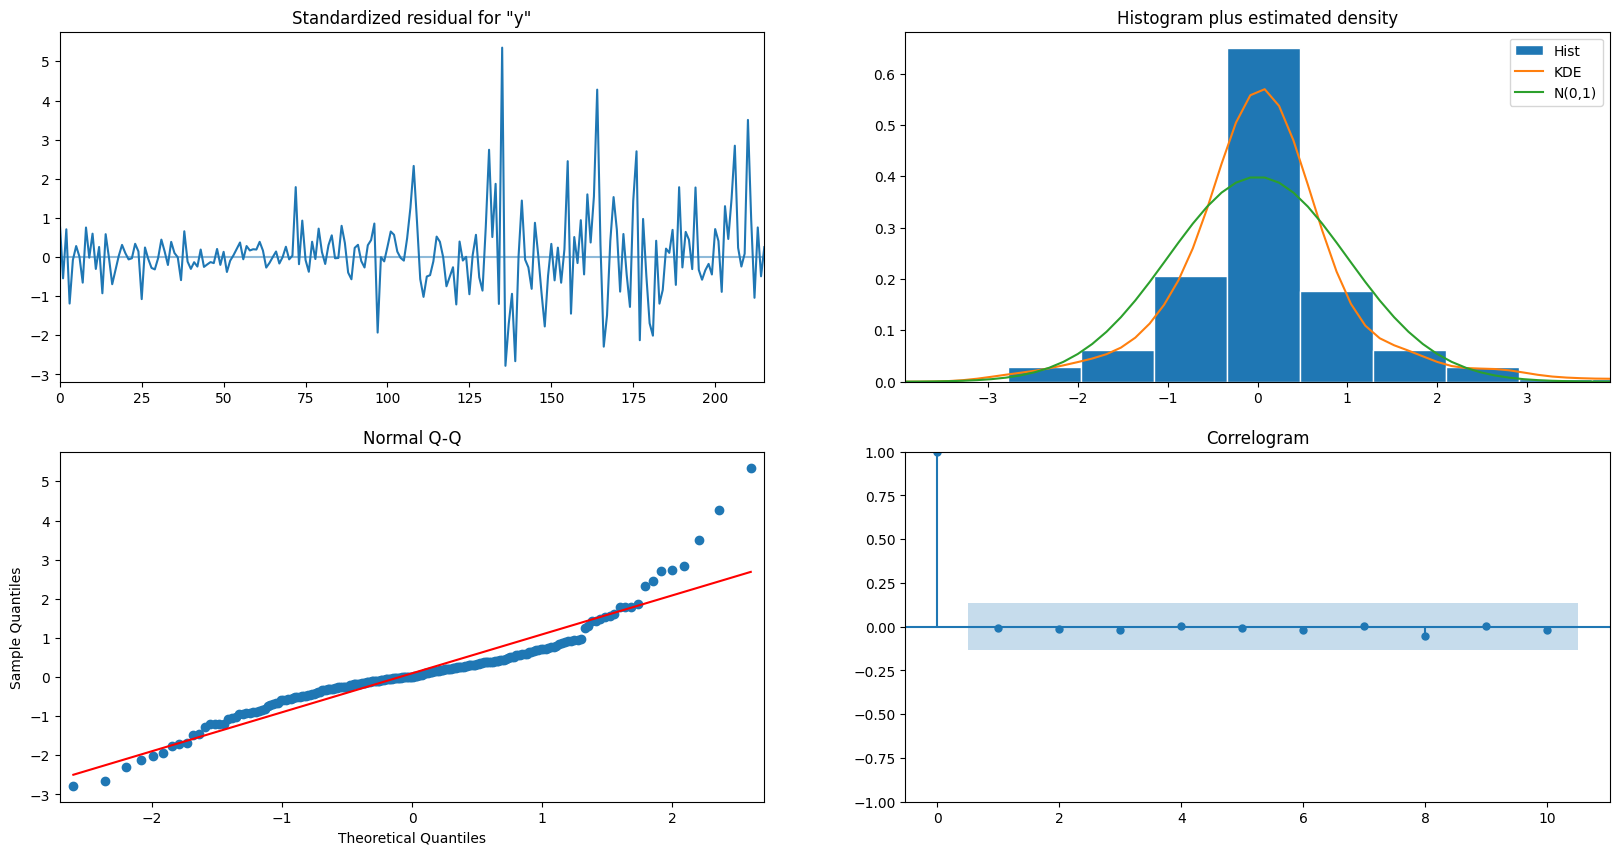

In [19]:
model_fit.plot_diagnostics(figsize=(20,10))
plt.show()

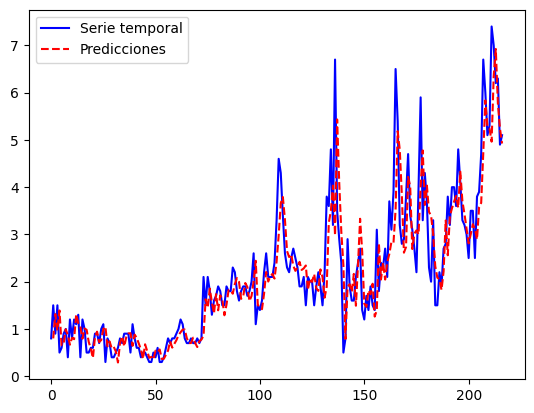

In [20]:
# Tomamos predicciones
preds = model_fit.predict()
# Creamos figura
fig, ax = plt.subplots()
ax.plot(range(len(ipc)), ipc.values, 'b-')
ax.plot(range(1,len(ipc)), preds[1:], 'r--')
plt.legend(['Serie temporal', 'Predicciones'])
plt.show()

Predicho=1.973800, Valor real=1.900000
Predicho=3.037092, Valor real=1.600000
Predicho=2.189122, Valor real=1.600000
Predicho=1.375653, Valor real=2.100000
Predicho=2.199072, Valor real=2.400000
Predicho=3.098038, Valor real=2.700000
Predicho=2.682737, Valor real=1.400000
Predicho=1.931754, Valor real=1.200000
Predicho=1.448371, Valor real=1.700000
Predicho=1.828754, Valor real=1.400000
Predicho=1.823543, Valor real=1.900000
Predicho=2.006042, Valor real=1.500000
Predicho=1.575810, Valor real=1.400000
Predicho=1.597886, Valor real=3.100000
Predicho=2.641240, Valor real=1.800000
Predicho=2.229835, Valor real=2.400000
Predicho=2.271092, Valor real=2.300000
Predicho=2.097554, Valor real=2.700000
Predicho=2.482139, Valor real=2.100000
Predicho=2.475317, Valor real=3.700000
Predicho=2.605487, Valor real=3.100000
Predicho=3.152324, Valor real=3.900000
Predicho=3.255587, Valor real=6.500000
Predicho=5.184147, Valor real=5.400000
Predicho=5.419160, Valor real=3.200000
Predicho=3.918361, Valor 

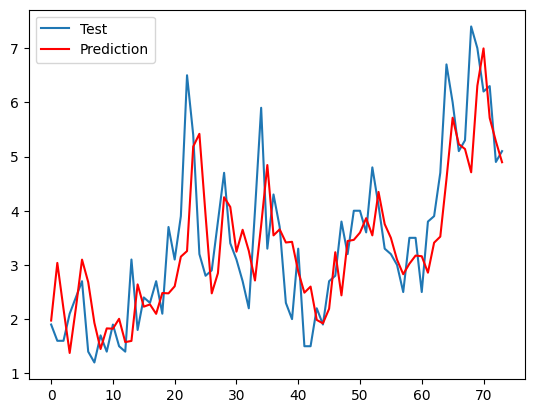

In [21]:
# Partimos datos para asegurar una validación final en datos test
X = ipc.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# Walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(8,1,1))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('Predicho=%f, Valor real=%f' % (yhat, obs))
# Evaluamos los resultados
metric = lambda x,y : np.sqrt(np.mean((x-y)**2))
rmse = np.sqrt(metric(test, predictions))
mape = np.mean(np.abs(predictions - test)/np.abs(test))  # MAPE
print('Test RMSE: %.3f' % rmse)
print("Test MAPE: %.3f" % mape)
# Dibujamos valor real y predicho
plt.plot(test)
plt.plot(predictions, color='red',)
plt.legend(["Test","Prediction"])
plt.show()

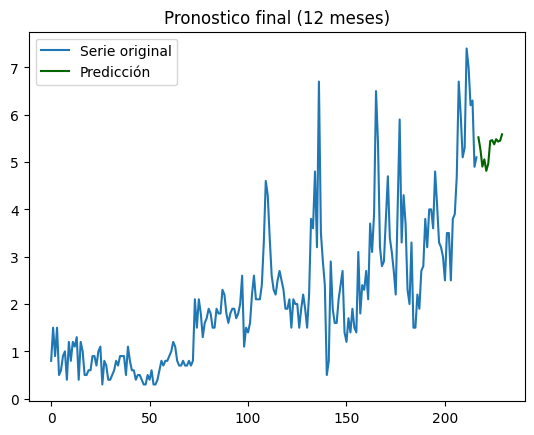

[5.52277077 5.26825204 4.90362904 5.0569651  4.81403047 4.96768265
 5.4474125  5.46244198 5.37474489 5.48295512 5.43303108 5.44979314
 5.58631082]


In [22]:
# pronostico
pasos = 13
start=len(ipc)
end=start + pasos-1
fc = model_fit.predict(start=start,end=end)
index_of_fc = np.arange(len(ipc.values), len(ipc.values)+pasos)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
# lower_series = pd.Series(confint[:, 0], index=index_of_fc)
# upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(ipc.values)
plt.plot(fc_series, color='darkgreen')
# plt.fill_between(lower_series.index, 
#                  lower_series, 
#                  upper_series, 
#                  color='k', alpha=.15)

plt.title("Pronostico final (12 meses)")
plt.legend(["Serie original","Predicción"])
plt.show()

# Mostramos los valores
print(fc)